Code from: https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html

Code By: Ahmed Gad

Comments by: Kuba Jerzmanowski

In [138]:
import skimage.data  
import numpy
import sys

img = skimage.data.chelsea()  
img = skimage.color.rgb2gray(img)
#here we jus import the image

In [139]:
l1_filter = numpy.zeros((2,3,3)) #prep empty filters so like a array with zeros

In [140]:
#not how its done in deep ML but for our sake of vizualization we will hardcode feature values
l1_filter[0, :, :] = numpy.array([[[-1, 0, 1],   
                                    [-1, 0, 1],   
                                    [-1, 0, 1]]])  #virtival edge filter

l1_filter[1, :, :] = numpy.array([[[1,   1,  1],   
                                    [0,   0,  0],   
                                    [-1, -1, -1]]]) #horizontal edge filter

In [141]:
#So this function does the actual work of applying the filter
#we pass in the img and the filter and do the math
def conv_(img, conv_filter):  
    filter_size = conv_filter.shape[0]  
    result = numpy.zeros((img.shape))  
    #this looks scarry but its just from row 0 to the max row in the range we iterate over the rows
    for r in numpy.uint16(numpy.arange(filter_size/2, img.shape[0]-filter_size/2-2)):  
        #now over the colomns as we did abovr
        for c in numpy.uint16(numpy.arange(filter_size/2, img.shape[1]-filter_size/2-2)):  
            
            #the first spot and so on we calc the cur region given that r,c is the left for corner of the filter
            curr_region = img[r:r+filter_size, c:c+filter_size]  

           #multiply the filter by the region
            curr_result = curr_region * conv_filter  
            conv_sum = numpy.sum(curr_result) #the center value is the sum of the values of all the squares in the cov filter so we sum
            result[r, c] = conv_sum #save the res
             
   #so the conv has been applyed but we must trim of the edges where the conv was not applyed 
    final_result = result[numpy.uint16(filter_size/2):result.shape[0]-numpy.uint16(filter_size/2),   
                         numpy.uint16(filter_size/2):result.shape[1]-numpy.uint16(filter_size/2)]  
    return final_result

In [142]:
def conv(img, conv_filter):      
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: #we make sure that the filers and img actually have shape 
        #we got on to do some checks that all just ensure that the oppertion will be valid
        if img.shape[-1] != conv_filter.shape[-1]:              
            print("Error: Number of channels in both image and filter must match.")              
            sys.exit()      
        if conv_filter.shape[1] != conv_filter.shape[2]:    
            print('Error: Filter must be a square matrumber of rows and columns must match.')          
            sys.exit()      
        if conv_filter.shape[1]%2==0: 
            print('Error: Filter must have an odd siumber of rows and columns must be odd.')  
            sys.exit()  
 
    #no padding or any thing so the feature map (result of putting cov across the img) will decrease the size of the img. 
    # like if first dim is 10 and cov filter is 7 then you would get 4 convolutions is stride=1 and padding zero so 10-7+1=4
    feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1,   
                               img.shape[1]-conv_filter.shape[1]+1,   
                               conv_filter.shape[0]))  
 
   #for each filter because we often want many filters to extrcat many features
    for filter_num in range(conv_filter.shape[0]):  
        print("Filter ", filter_num + 1)  
        curr_filter = conv_filter[filter_num, :]
        if len(curr_filter.shape) > 2:  
           conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0])
           for ch_num in range(1, curr_filter.shape[-1]):
               conv_map = conv_map + conv_(img[:, :, ch_num],   
                                 curr_filter[:, :, ch_num])  
        else: #this just the case when the filter have depth of 1 so like on a B&W image it woudl have depth of one but on the RGB image it woudl have depth (channels) of 3 for the first covolution layer
           conv_map = conv_(img, curr_filter)  
        feature_maps[:, :, filter_num] = conv_map 
    return feature_maps

In [143]:
#ok so this is a very simple triple nested for loop to allpy ReLU on each point
def relu(feature_map):  
    relu_out = numpy.zeros(feature_map.shape)  # we copy shape of the input 
    for map_num in range(feature_map.shape[-1]):   # since we can have many posible feature maps so we do this individual per map
         #now within the F_map we just apply ReLU to each point
        for r in numpy.arange(0,feature_map.shape[0]):  
            for c in numpy.arange(0, feature_map.shape[1]):  
                relu_out[r, c, map_num] = numpy.max(feature_map[r, c, map_num], 0)  
    return relu_out   

In [144]:
def pooling(feature_map, size=2, stride=2): 
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride),  
                             numpy.uint16((feature_map.shape[1]-size+1)/stride),  
                             feature_map.shape[-1]))  
    for map_num in range(feature_map.shape[-1]):  #again since we can have many posible feature maps so we do this individual per map
        #r2 and c2 will keep track of where we are in the output map
        #the nested for loop will move across the img acording to the stride and size and then do classic max pooling
        r2 = 0  
        for r in numpy.arange(0,feature_map.shape[0]-size-1, stride):  
            c2 = 0  
            for c in numpy.arange(0, feature_map.shape[1]-size-1, stride):  
                pool_out[r2, c2, map_num] = numpy.max(feature_map[r:r+size,  c:c+size])  
                c2 = c2 + 1  
            r2 = r2 +1 
    return pool_out 

In [145]:
l1_feature_map = conv(img, l1_filter)  

Filter  1
Filter  2


In [146]:
l1_feature_map_relu = relu(l1_feature_map)

In [147]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)

In [148]:
# Second conv layer  
l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])  #now we just pci random numbers for the filter its 3 filters with 5x5 conv and they have have num channels from the previous layer
print("\n**Working with conv layer 2**")  
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)  
print("\n**ReLU**")  
l2_feature_map_relu = relu(l2_feature_map)  
print("\n**Pooling**")  
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)  
print("**End of conv layer 2**\n") 


**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**



In [149]:
# Third conv layer  
l3_filter = numpy.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])  #again but now we do 7x7 conv and one feature map
print("\n**Working with conv layer 3**")  
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)  
print("\n**ReLU**")  
l3_feature_map_relu = relu(l3_feature_map)  
print("\n**Pooling**")  
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)  
print("**End of conv layer 3**\n")  


**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**



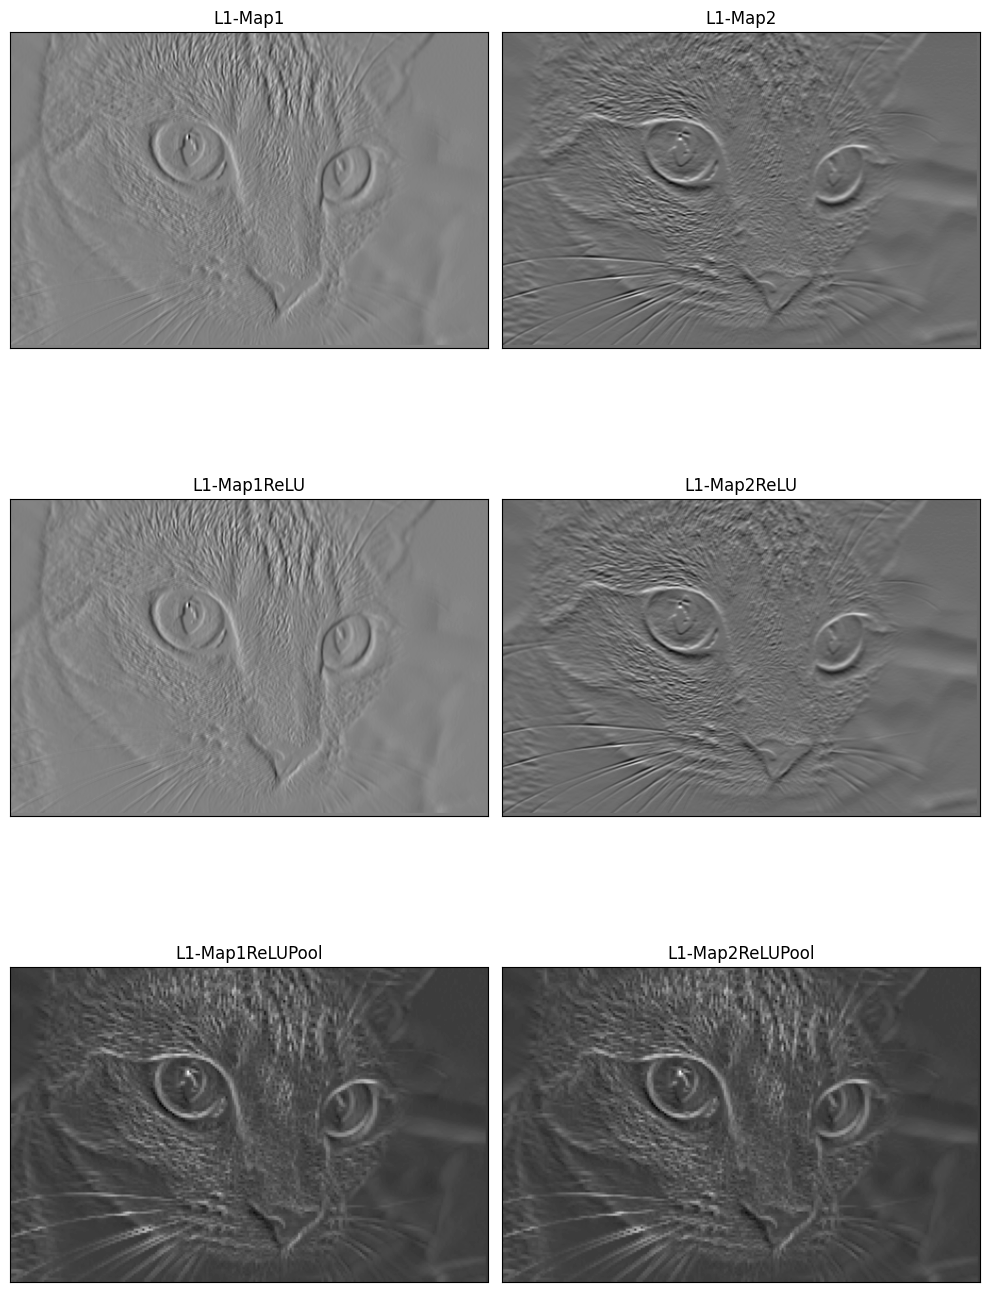

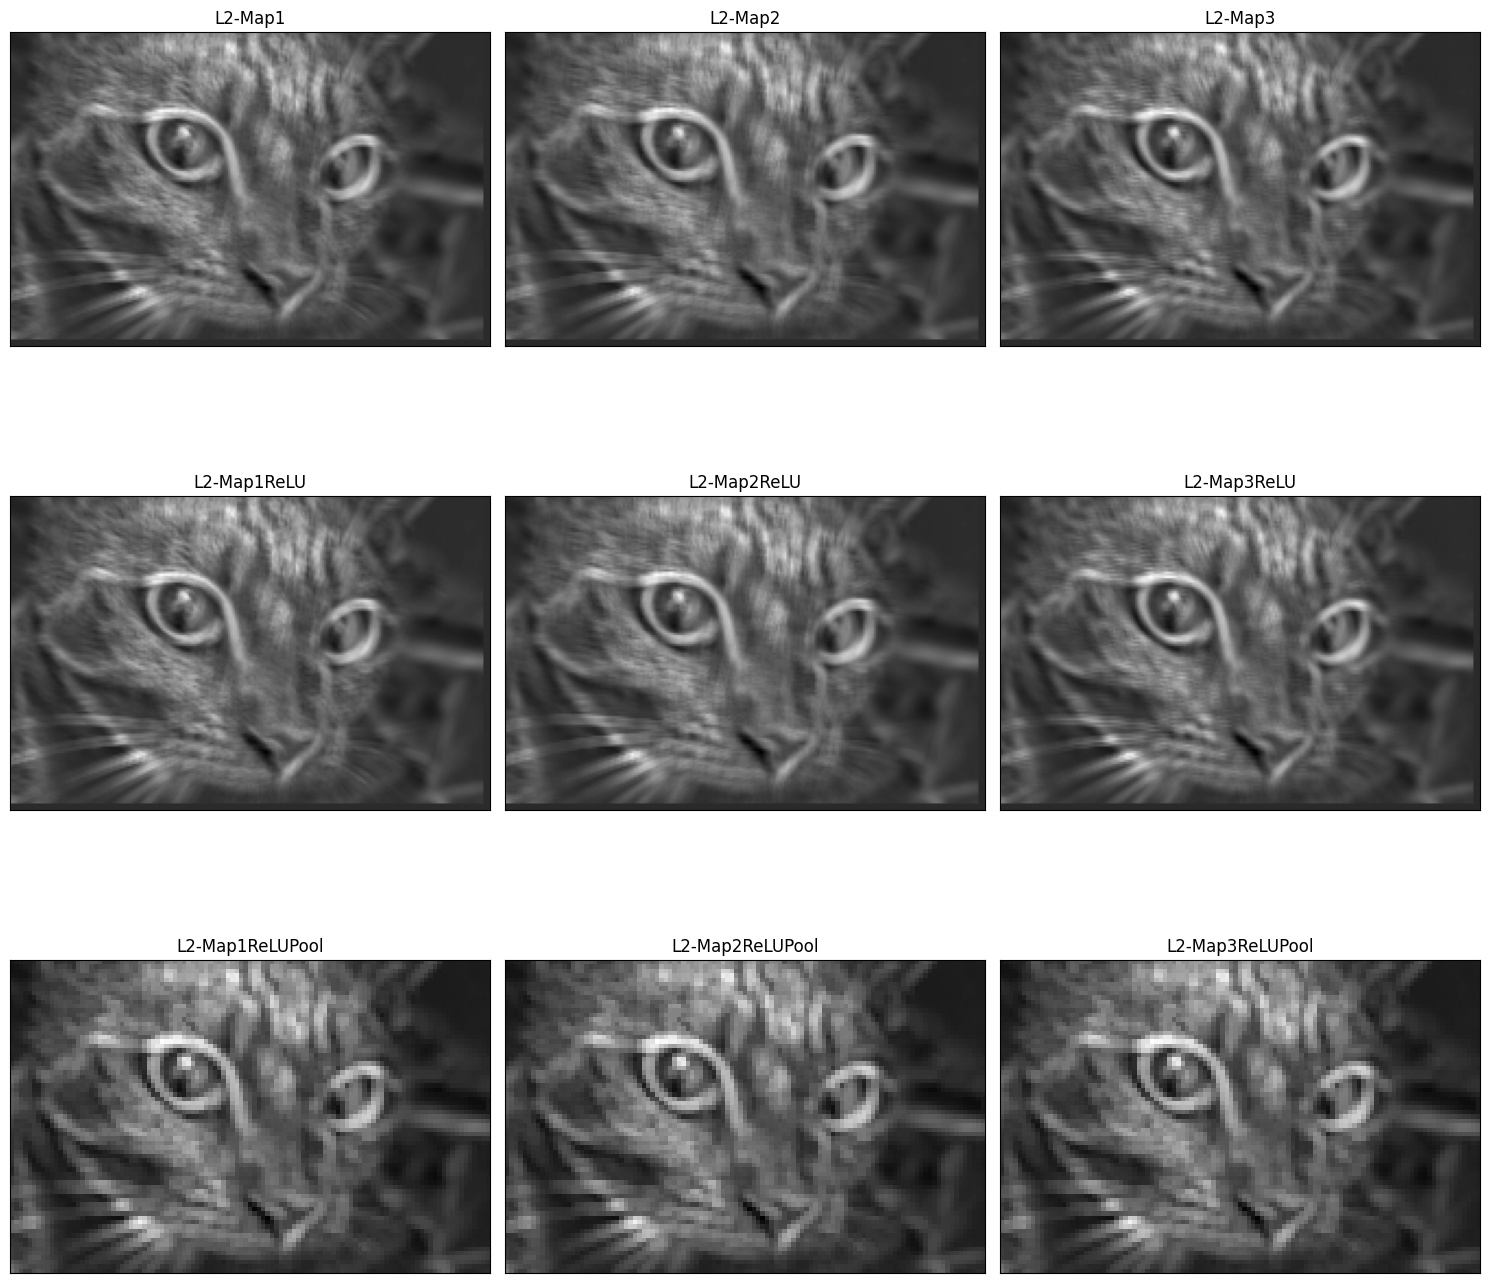

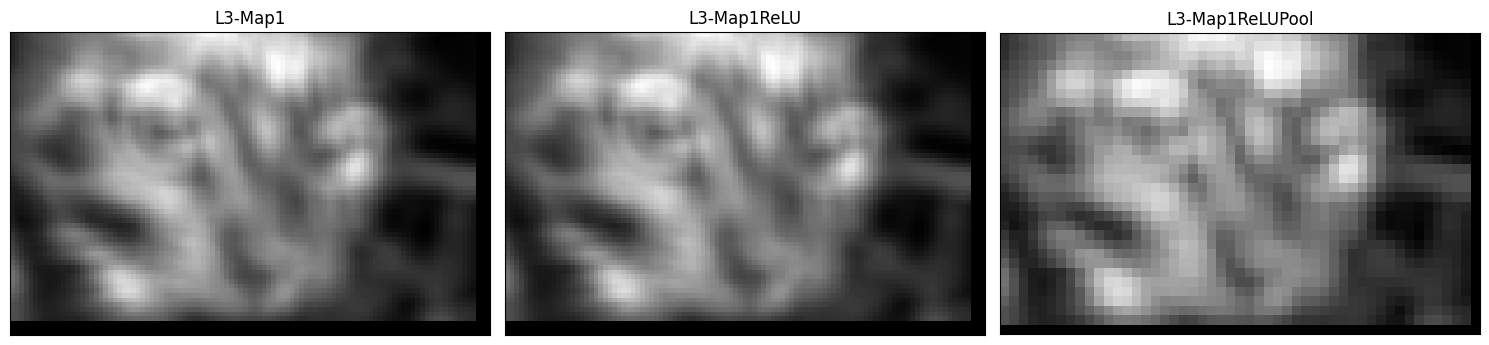

In [150]:
import matplotlib.pyplot as plt

# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
ax1[0, 0].imshow(l1_feature_map[:, :, 0], cmap="gray")
ax1[0, 0].set_xticks([])
ax1[0, 0].set_yticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_map[:, :, 1], cmap="gray")
ax1[0, 1].set_xticks([])
ax1[0, 1].set_yticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_map_relu[:, :, 0], cmap="gray")
ax1[1, 0].set_xticks([])
ax1[1, 0].set_yticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_map_relu[:, :, 1], cmap="gray")
ax1[1, 1].set_xticks([])
ax1[1, 1].set_yticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_map_relu_pool[:, :, 0], cmap="gray")
ax1[2, 0].set_xticks([])
ax1[2, 0].set_yticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_map_relu_pool[:, :, 1], cmap="gray")
ax1[2, 1].set_xticks([])
ax1[2, 1].set_yticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

plt.tight_layout()
plt.show()
plt.close(fig1)

# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax2[0, 0].imshow(l2_feature_map[:, :, 0], cmap="gray")
ax2[0, 0].set_xticks([])
ax2[0, 0].set_yticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_map[:, :, 1], cmap="gray")
ax2[0, 1].set_xticks([])
ax2[0, 1].set_yticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_map[:, :, 2], cmap="gray")
ax2[0, 2].set_xticks([])
ax2[0, 2].set_yticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_map_relu[:, :, 0], cmap="gray")
ax2[1, 0].set_xticks([])
ax2[1, 0].set_yticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_map_relu[:, :, 1], cmap="gray")
ax2[1, 1].set_xticks([])
ax2[1, 1].set_yticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_map_relu[:, :, 2], cmap="gray")
ax2[1, 2].set_xticks([])
ax2[1, 2].set_yticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_map_relu_pool[:, :, 0], cmap="gray")
ax2[2, 0].set_xticks([])
ax2[2, 0].set_yticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_map_relu_pool[:, :, 1], cmap="gray")
ax2[2, 1].set_xticks([])
ax2[2, 1].set_yticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_map_relu_pool[:, :, 2], cmap="gray")
ax2[2, 2].set_xticks([])
ax2[2, 2].set_yticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")

plt.tight_layout()
plt.show()
plt.close(fig2)

# Layer 3
fig3, ax3 = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax3[0].imshow(l3_feature_map[:, :, 0], cmap="gray")
ax3[0].set_xticks([])
ax3[0].set_yticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_map_relu[:, :, 0], cmap="gray")
ax3[1].set_xticks([])
ax3[1].set_yticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_map_relu_pool[:, :, 0], cmap="gray")
ax3[2].set_xticks([])
ax3[2].set_yticks([])
ax3[2].set_title("L3-Map1ReLUPool")

plt.tight_layout()
plt.show()
plt.close(fig3)